In [3]:
#figdir = '/home/kpmurphy/github/rebayes/demos/figures' # TPU
figdir = '/Users/kpmurphy/github/rebayes/demos/figures' # laptop

In [4]:
# Gerardo's
figdir = "./showdown/output/images/"

In [5]:
import re
import jax
import distrax
import optax
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree
from jax import vmap
import flax.linen 
import flax.linen as nn
from flax.training.train_state import TrainState


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from typing import Callable, Tuple, Any
from tqdm.notebook import tqdm
import itertools
from itertools import product
import time
import copy

import rebayes
from rebayes import base
from rebayes.base import Rebayes
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd
from rebayes.sgd_filter import replay_sgd as rsgd

In [6]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
# plt.rcParams["lines.linewidth"] = 2

In [7]:
%config InlineBackend.figure_format = "retina"

# Data

In [8]:
def make_1d_regression(n_train=100, n_test=100, key=0, sort_data=False, coef=jnp.array([2.0,3.0])):
    if isinstance(key, int): key = jr.PRNGKey(key)
    key1, key2, subkey1, subkey2, key_shuffle = jr.split(key, 5)

    def gen1(key, x):
        epsilons = jr.normal(key1, shape=(3,))*0.02
        return (x + 0.3*jnp.sin(coef[0]*jnp.pi*(x+epsilons[0])) +
                0.3*jnp.sin(coef[1]*jnp.pi*(x+epsilons[1])) + epsilons[2])
    
    def gen(key, x):
        # coef0 = phase, coef1=freq
        noise = jr.normal(key, shape=(1,))*0.02
        return (x + 0.3*jnp.sin(coef[0] + coef[1]*jnp.pi*x))+noise
    
    X_train = jr.uniform(key1, shape=(n_train, 1), minval=-0.5, maxval=0.5)
    X_test = jr.uniform(key2, shape=(n_test, 1), minval=-0.5, maxval=0.5)
    
    keys_train = jr.split(subkey1, X_train.shape[0])
    keys_test = jr.split(subkey2, X_test.shape[0])
    y_train = vmap(gen)(keys_train, X_train)
    y_test = vmap(gen)(keys_test, X_test)

    # Standardize dataset
    if True:
        X_train = (X_train - X_train.mean()) / X_train.std()
        y_train = (y_train - y_train.mean()) / y_train.std()
        X_test = (X_test - X_test.mean()) / X_test.std()
        y_test = (y_test - y_test.mean()) / y_test.std()

    return X_train, y_train, X_test, y_test

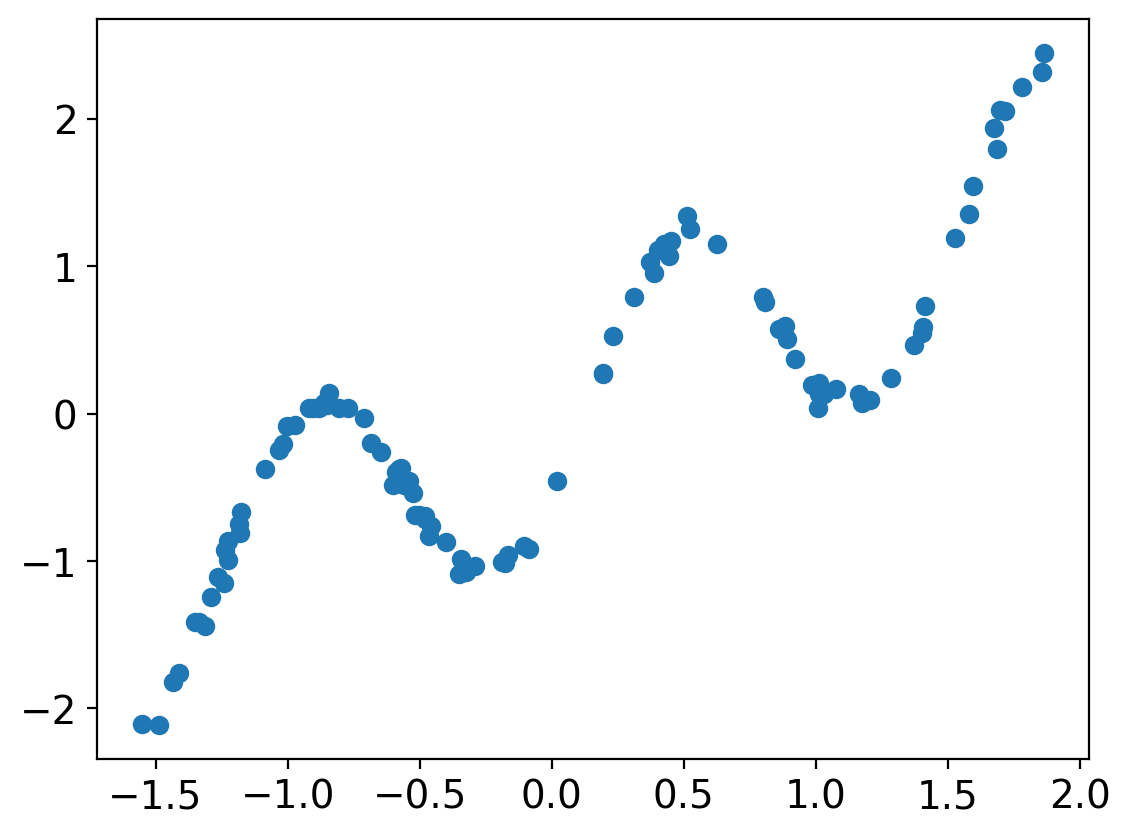

In [9]:
X_train, y_train, X_test, y_test = make_1d_regression(coef=jnp.array([0.0, 5.0]))
plt.figure()
plt.plot(X_train, y_train, 'o')

In [12]:
def make_coef(n_dist = 9, start=1, stop=-2, sf=3, key=0):
    if isinstance(key, int): key = jr.PRNGKey(key)
    key1, key2, key = jr.split(key, 3)
    c0 = jr.uniform(key1,  shape=(n_dist,), minval=-5, maxval=5)
    #c0 = jnp.linspace(start=start, stop=stop, num=n_dist) # phase
    #c1 = sf*c0 # jnp.linspace(start=-1, stop=2, num=n_dist)
    #c1 = jnp.ones(n_dist) * sf # frequency
    c1 = jr.uniform(key2,  shape=(n_dist,), minval=-5, maxval=5)
    coefs = jnp.vstack([c0,c1]).T
    return coefs


def make_regression_tasks(coefs, n_train=100, n_test=100, key=0):
    n_dist = coefs.shape[0]
    def gen(c): return make_1d_regression(coef=c, n_train=n_train, n_test=n_test, key=key)
    X_train, y_train, X_test, y_test  = vmap(gen)(coefs)
    return X_train, y_train, X_test, y_test


def concatenate_tasks(X_train, y_train, X_test, y_test):
    n_dist, n_train, d_train = X_train.shape
    n_dist, n_test, d_test = X_test.shape
    X_train = jnp.hstack(X_train[:,:,0])
    X_test = jnp.hstack(X_test[:,:,0])
    y_train = jnp.hstack(y_train[:,:,0])
    y_test = jnp.hstack(y_test[:,:,0])
    task_id_train = jnp.concatenate([i*jnp.ones(n_train, dtype=int) for i in range(n_dist)])
    task_id_test = jnp.concatenate([i*jnp.ones(n_test, dtype=int) for i in range(n_dist)])
    #return X_train, y_train, X_test, y_test, task_id_train, task_id_test
    return X_train[:,jnp.newaxis], y_train[:,jnp.newaxis], X_test[:,jnp.newaxis], y_test[:,jnp.newaxis], task_id_train, task_id_test

def make_1d_regression_sequence(coefs, n_train=100, n_test=100, key=0):
    X_train, y_train, X_test, y_test = make_regression_tasks(coefs, n_train, n_test, key)
    X_train_seq, y_train_seq, X_test_seq, y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(X_train, y_train, X_test, y_test)
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq, train_id_seq, test_id_seq

In [13]:
def plot_tasks(X_train, Y_train, X_test, Y_test, nr=None, nc=None, figsize=None):
    figsize = (10, 10) if figsize is None else figsize
    ntasks = X_train.shape[0]
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    if nr is None:
        nr = int(np.floor(np.sqrt(ntasks)))
        nc = int(np.ceil(np.sqrt(ntasks)))
    #fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    fig, axs = plt.subplots(nr, nc, figsize=figsize)
    axs = axs.flat
    for i in range(ntasks):
        ax = axs[i]
        ax.plot(X_train[i], Y_train[i], 'x', markersize=12, color=colors[i], label='train {:d}'.format(i))
        ax.plot(X_test[i], Y_test[i], 'o', color=colors[i], label='test {:d}'.format(i))
        ax.set_title(i)
    #plt.legend()


def plot_tasks_together(X_train, Y_train, X_test, Y_test, task_id_train, task_id_test):
    ntasks = len(np.unique(task_id_train))
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    plt.figure()
    for i in range(ntasks):
        ndx_train = (task_id_train == i)
        plt.plot(X_train[ndx_train], Y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        plt.plot(X_test[ndx_test], Y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
    plt.legend()

def plot_tasks_separately(X_train, Y_train, X_test, Y_test, task_id_train, task_id_test, figsize=None):
    figsize = (10, 10) if figsize is None else figsize
    ntasks = len(np.unique(task_id_train))
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    nr = int(np.floor(np.sqrt(ntasks)))
    nc = int(np.ceil(np.sqrt(ntasks)))
    #fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    fig, axs = plt.subplots(nr, nc, figsize)
    axs = axs.flat
    for i in range(ntasks):
        ax = axs[i]
        ndx_train = (task_id_train == i)
        ax.plot(X_train[ndx_train], Y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        ax.plot(X_test[ndx_test], Y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
        ax.set_title(i)
    #plt.legend()

[[-0.758 -0.29 ]
 [ 3.342  1.447]
 [ 4.084 -3.199]
 [ 0.572  2.492]
 [ 2.563  2.502]
 [-4.714  2.407]]
(6, 200, 1) (6, 200, 1)
(1200, 1) (1200, 1)


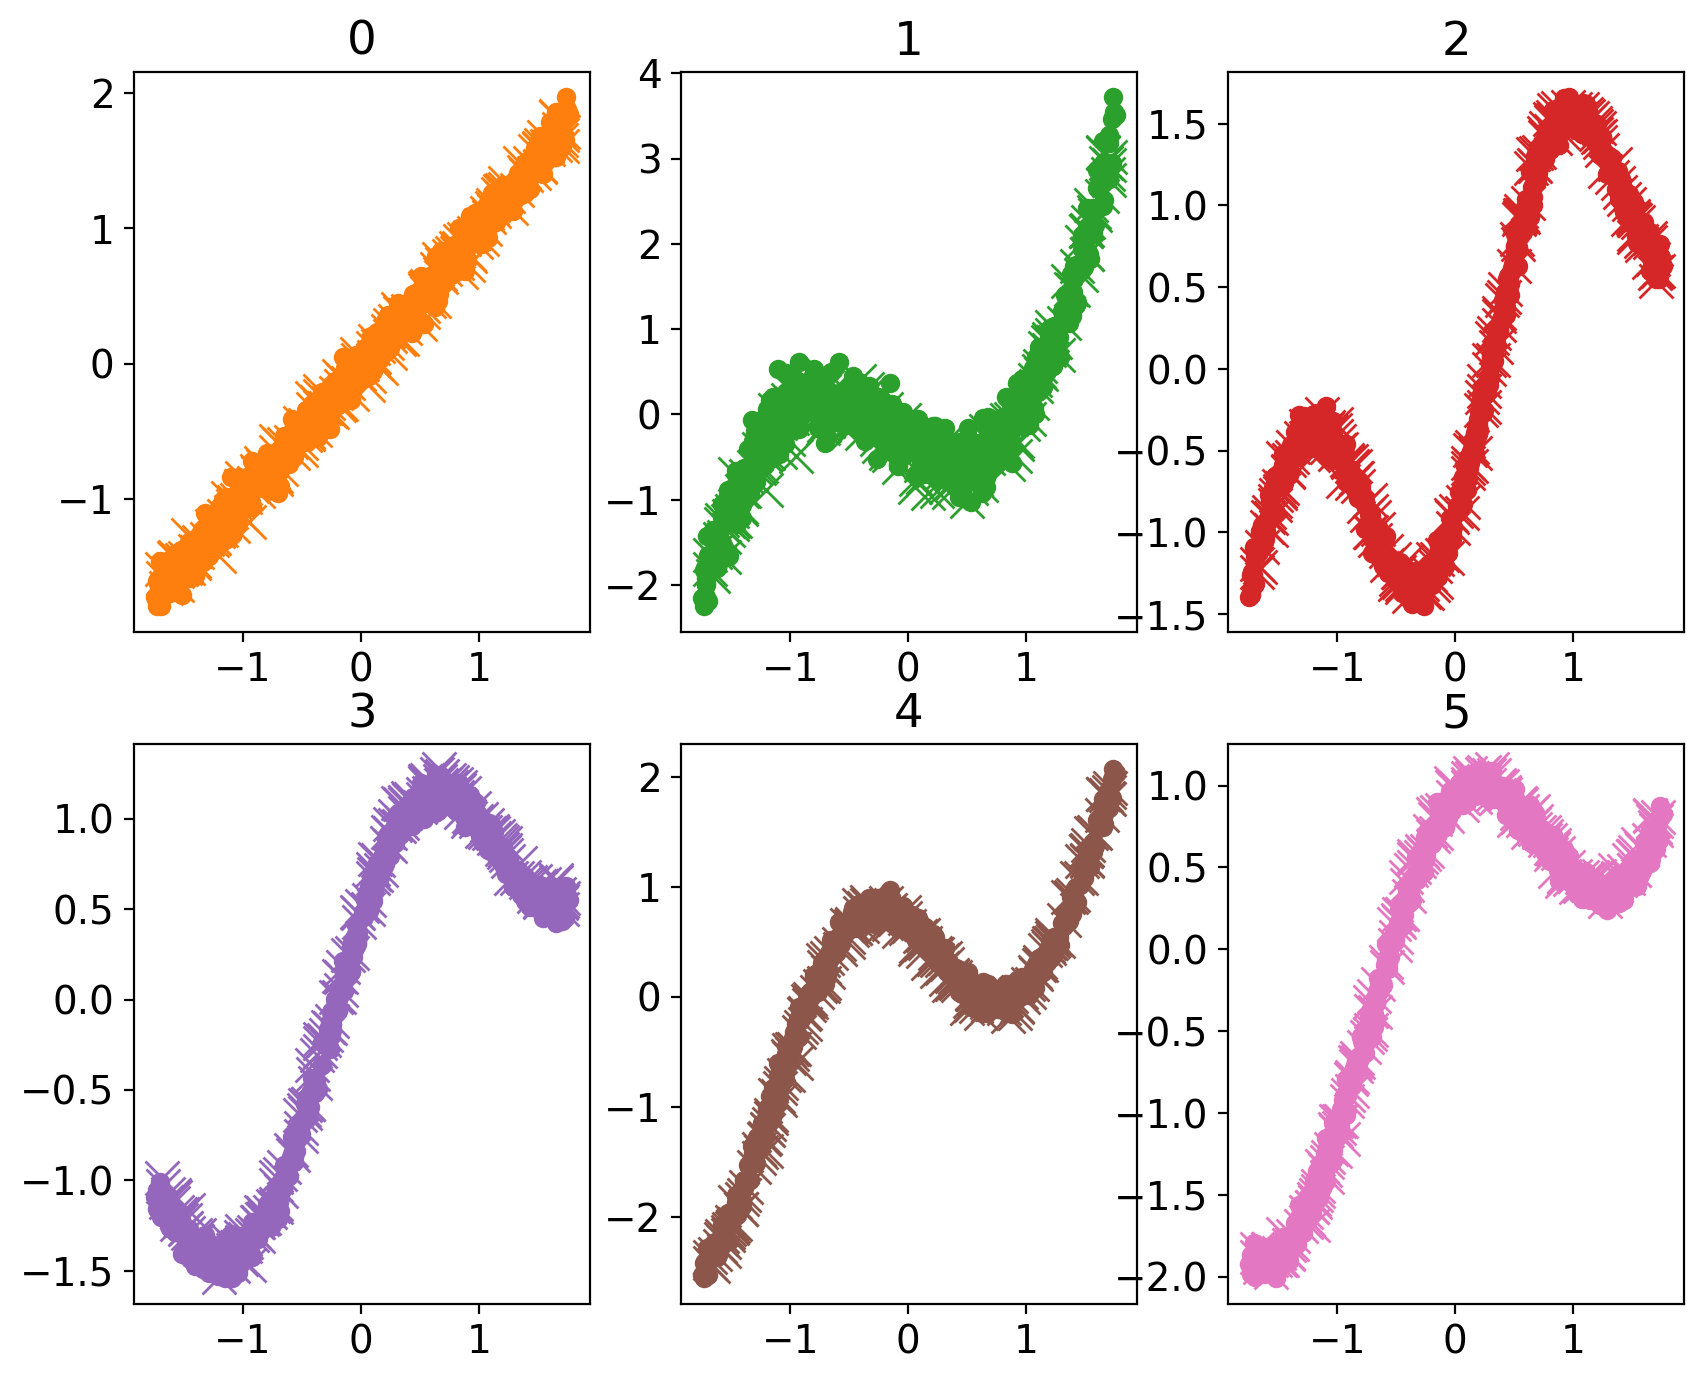

In [14]:
ntasks = 6
coefs = make_coef(n_dist = ntasks, key=2)

with np.printoptions(precision=3, suppress=True):
    print(coefs)
    

X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks = make_regression_tasks(coefs, n_train=200, n_test=500, key=314)

X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(
    X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

print(X_train_tasks.shape, Y_train_tasks.shape)
print(X_train_seq.shape, Y_train_seq.shape)

figsize = (10, 8)
plot_tasks(X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks, figsize=figsize)

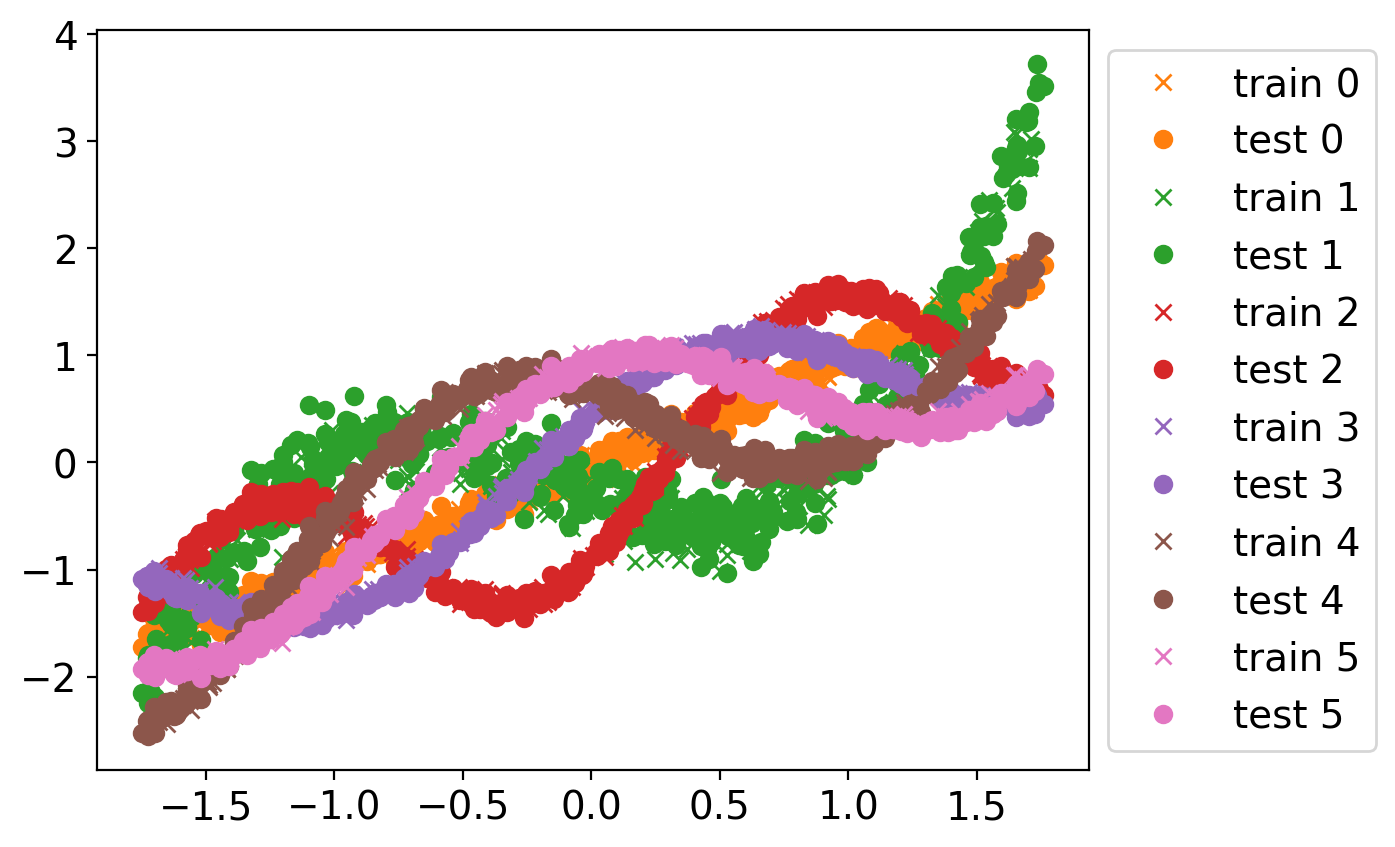

In [15]:
plot_tasks_together(X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq)
plt.legend(bbox_to_anchor=(1,1))

# Rebayes

In [16]:
class MLP(flax.linen.Module):
    n_in: int
    n_out: int
    n_hidden: int
    activation: Callable = flax.linen.elu
    
    @flax.linen.compact
    def __call__(self, x):
        x = flax.linen.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = flax.linen.Dense(self.n_out)(x)
        return x

def make_bnn_flax(nhidden = 50):    
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_in, dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

def inspect_model(model, params, flat_params):
    inputs = jnp.ones((1, model.n_in))
    print(model.tabulate(jax.random.PRNGKey(0), inputs))
    b0 = params['params']['Dense_0']['bias']
    w0 = params['params']['Dense_0']['kernel'].squeeze()
    b1 = params['params']['Dense_1']['bias']
    w1 = params['params']['Dense_1']['kernel'].squeeze()
    fp = jnp.concatenate([b0, w0, b1, w1])
    #print(b0.shape, fp.shape, flat_params.shape)
    assert jnp.allclose(fp, flat_params)
    assert jnp.allclose(fp[:model.n_hidden], b0)
    assert jnp.allclose(b0, jnp.zeros(model.n_hidden))

model, dnn_params, flat_params, recfn = make_bnn_flax()
inspect_model(model, dnn_params, flat_params)

                    MLP Summary                    
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs       ┃ params                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[1,1]  │                       │
├─────────┼───────────────┼───────────────────────┤
│ Dense_0 │ float32[1,50] │ bias: float32[50]     │
│         │               │ kernel: float32[1,50] │
│         │               │                       │
│         │               │ 100 (400 B)           │
├─────────┼───────────────┼───────────────────────┤
│ Dense_1 │ float32[1,1]  │ bias: float32[1]      │
│         │               │ kernel: float32[50,1] │
│         │               │                       │
│         │               │ 51 (204 B)            │
├─────────┼───────────────┼───────────────────────┤
│ MLP     │ float32[1,1]  │                       │
├─────────┼───────────────┼───────────────────────┤
│         │         Total │ 151 (604 B)           │
└─────────┴───────────────┴───────────────────────┘
                                                   
           Total Parameters: 151 (604 B)           

151
(6, 250, 1) (6, 250, 1)
(1500, 1) (1500, 1)


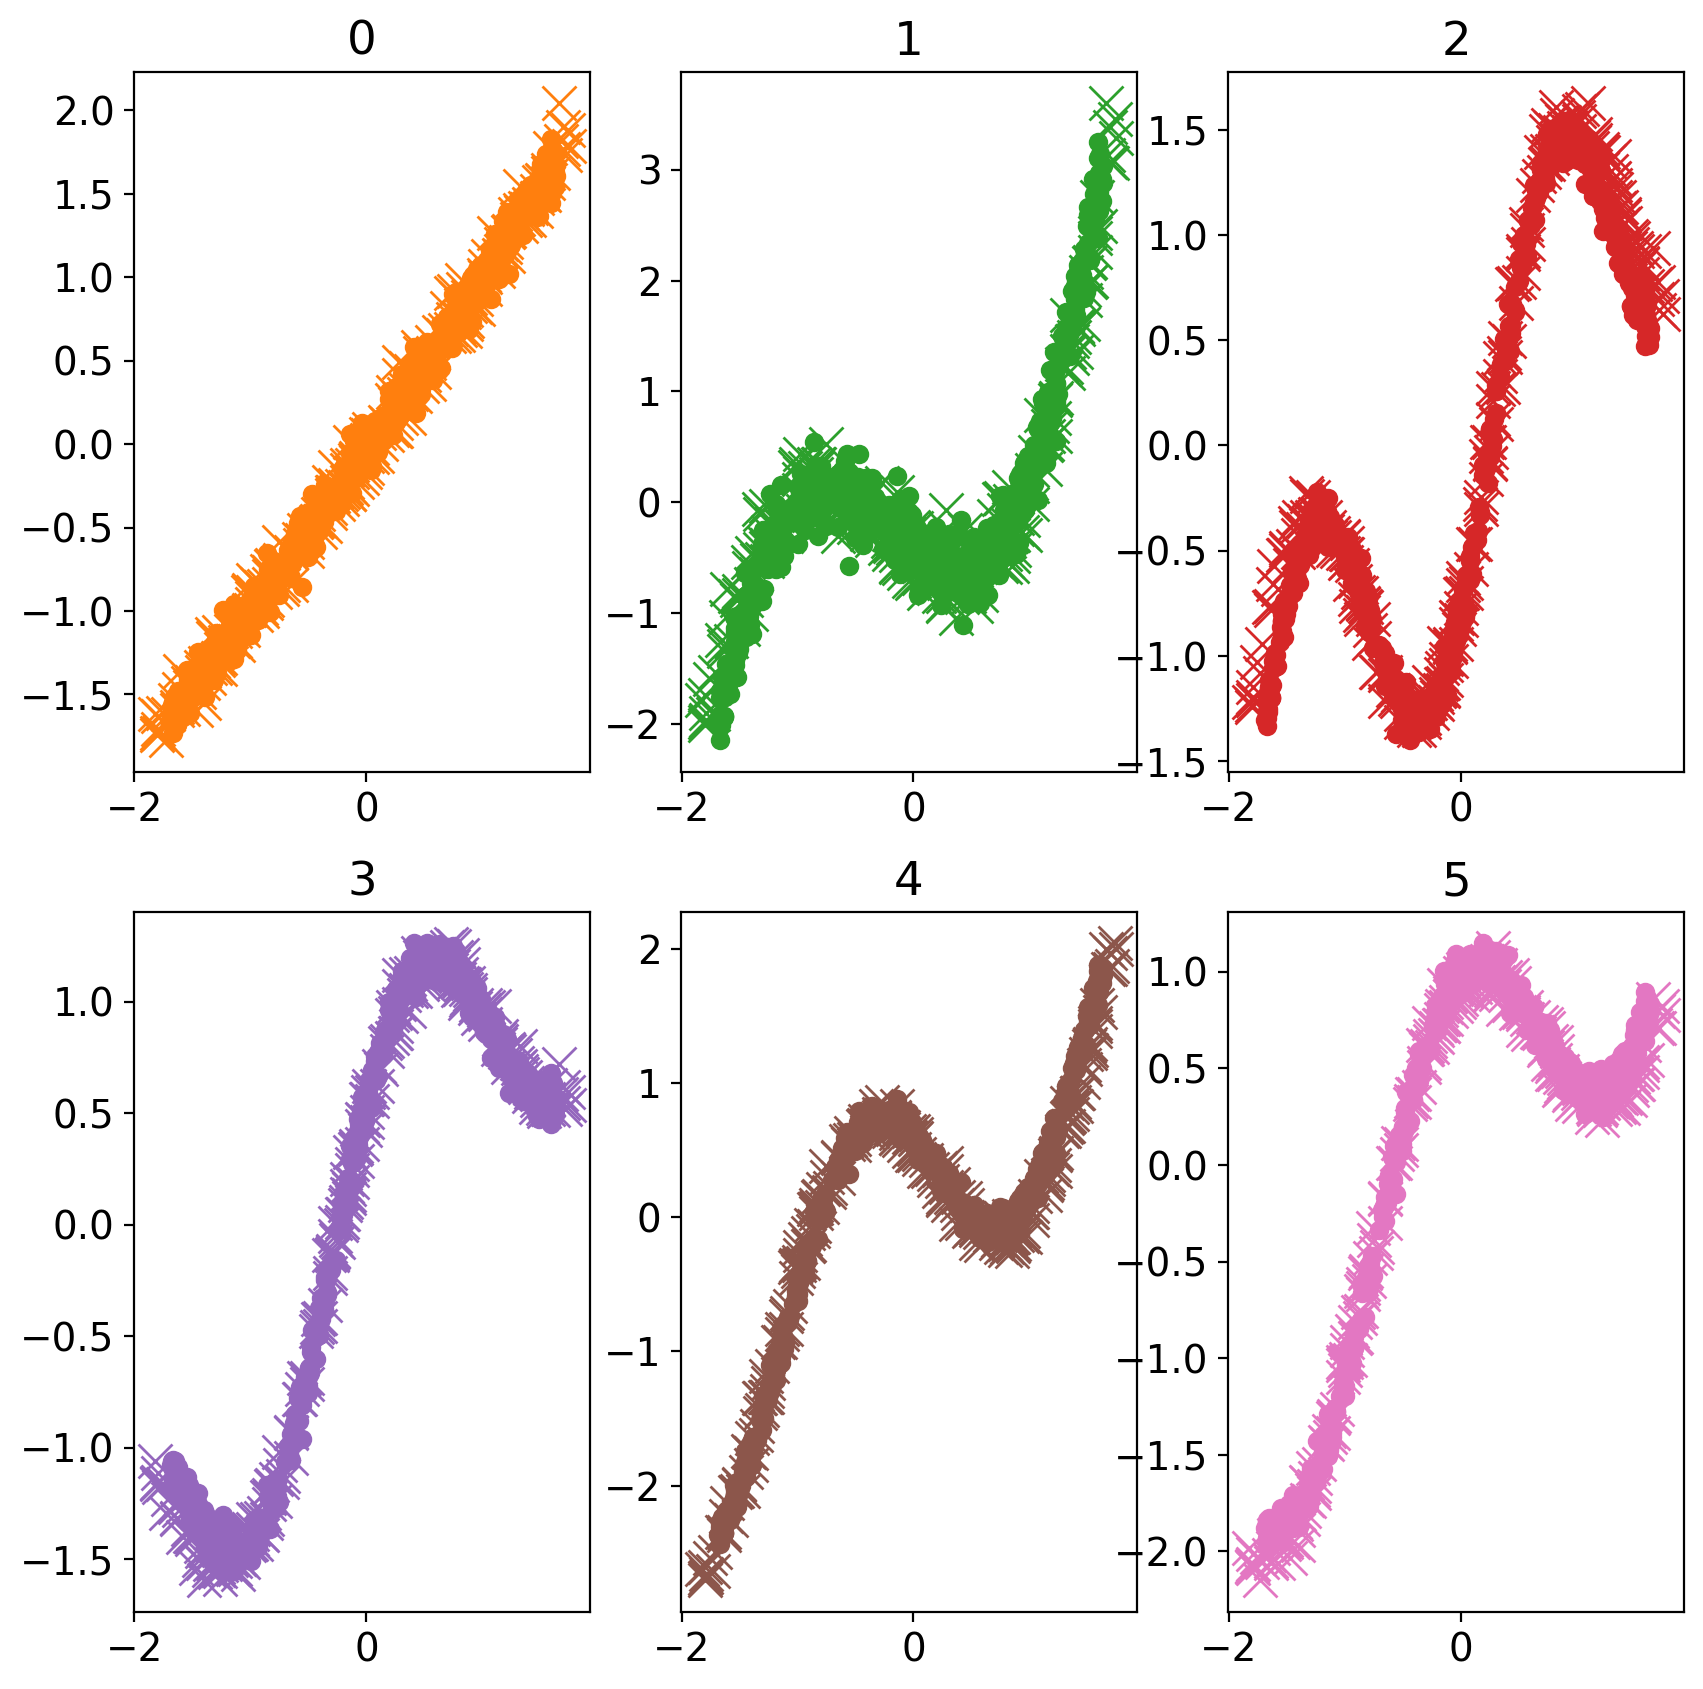

In [79]:
model, dnn_params, flat_params, recfn = make_bnn_flax()
print(len(flat_params))

def apply_fn_flat(flat_params, x):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x):
    return model.apply(params, x)

ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        # initial_covariance=0.01, # try 1.0, 10.
        initial_covariance=5.0,
        dynamics_weights=1,
        dynamics_covariance=0.01,
        emission_mean_function=apply_fn_flat,
        emission_cov_function = lambda w,x: 0.1,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=.001,
    )



@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_rmse_fifo(params, counter, X, y, apply_fn):
    yhat = apply_fn(params, X).ravel()
    y = y.ravel()
    err = jnp.power(y - yhat, 2)
    loss = (err * counter).sum() / counter.sum()
    return loss

ntasks = 6
coefs = make_coef(n_dist = ntasks, key=2)
X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks = make_regression_tasks(coefs, n_train=250, n_test=500, key=0)

X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(
    X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

print(X_train_tasks.shape, Y_train_tasks.shape)
print(X_train_seq.shape, Y_train_seq.shape)

plot_tasks(X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks) #, nr=1, nc=ntasks)



# callback depends on the test set - could pass as kwargs
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, apply_fn, **kwargs):
    #jax.debug.print("time={t}", t=t)
    #apply_fn = kwargs["apply_fn"]
    
    # eval on all tasks test set
    yhat = apply_fn(bel.mean, X_test_seq).squeeze()
    ytrue = Y_test_seq.squeeze()
    rmse_test_all_tasks = jnp.mean(jnp.square(yhat - ytrue)) 

    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test_tasks[task]).squeeze()
    #yhat = apply_fn_flat(bel.mean, X_test_tasks[task]).squeeze()
    ytrue = Y_test_tasks[task].squeeze()
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))

    out = {'rmse_test_all_tasks': rmse_test_all_tasks,
           'rmse_test_current_task': rmse_test_current_task,
           'mae_test_current_task': mae_test_current_task,
           'pred_test_current_task': yhat,
           }
    return out





In [80]:
method_list, estimator_list, callback_list = [], [], []

if 1:
    memory_list = [10]
    #q_list = [0, 0.01]
    q_list = [0.01]
    alpha_list = [0.01]
    combos = itertools.product(memory_list, q_list, alpha_list)
    for (mem, q, alpha) in combos:
        method = "lofi mem {:d}, q {:0.2f}, alpha {:0.2f}".format(mem, q, alpha)
        lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, diagonal_covariance=True)
        my_ssm_params = copy.deepcopy(ssm_params)
        my_ssm_params = my_ssm_params.replace(dynamics_covariance_inflation_factor = alpha, dynamics_covariance = q)
        estimator = lofi.RebayesLoFi(my_ssm_params, lofi_params, method="lofi", inflation="hybrid")
        method_list.append(method)
        estimator_list.append(estimator)
        callback_list.append(partial(callback, apply_fn = apply_fn_flat))


if 1:
    lr_list = [0.1]
    buffer_list = [1, 10]
    n_inner = 1
    combos = itertools.product(lr_list, buffer_list)
    for (lr, buffer) in combos:
        method = 'sgd lr {:0.3f} B {:d} E {:d}'.format(lr, buffer, n_inner)
        estimator = rsgd.FifoSGD(lossfn_rmse_fifo, 
                            apply_fn=apply_fn_unflat,
                            init_params = dnn_params,
                            tx = optax.adam(learning_rate=lr),
                            buffer_size = buffer,
                            dim_features = X_train_seq.shape[1],
                            dim_output = 1,
                            n_inner = n_inner)

        method_list.append(method)
        estimator_list.append(estimator)
        callback_list.append(partial(callback, apply_fn = apply_fn_unflat))

if 1:
    method = 'fcekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)
    callback_list.append(partial(callback, apply_fn = apply_fn_flat))


if 1:
    method = 'vdekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)
    callback_list.append(partial(callback, apply_fn = apply_fn_flat))

    method = 'fdekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)
    callback_list.append(partial(callback, apply_fn = apply_fn_flat))

In [81]:
# run the estmators

rmse_trace_list, elapsed_list, output_list  = [], [], []

for i, estimator in enumerate(estimator_list):
    t0 = time.time()
    bel, outputs = estimator.scan(X_train_seq, Y_train_seq, callback=callback_list[i])
    t1 = time.time()
    elapsed = t1-t0
    elapsed_list.append(elapsed)
    output_list.append(outputs)

In [82]:
def parse_name(method):
    parts = method.split()
    name = parts[0]
    numbers = re.findall(r"[-+]?(?:\d*\.*\d+)", method)
    if False: #name=='lofi':
        mem, q, alpha = numbers[0], float(numbers[1]), float(numbers[2])
        if q > 0:
            style = ':'
        else:
            style = '-.'
        if alpha > 0:
            marker = 'o'
        else:
            marker = 'x'
    elif name == 'lofi':
        style = ':'
        marker = 'o'
    elif name == 'sgd':
        style = '--'
        marker = 'x'
    elif "lrvga" in name:
        style = "dashdot"
        marker = "v"
    else:
        style = '-'
        marker = '*'
    return style, marker

def make_plot_dict(method_list):
    nmethods = len(method_list)
    colors = plt.cm.tab10(np.arange(nmethods)+1)
    color_dict, style_dict, marker_dict = {}, {}, {}
    for i, method in enumerate(method_list):
        style, marker = parse_name(method)
        style_dict[method] = style
        marker_dict[method] = marker
        color_dict[method] = colors[i,:]
    return color_dict, style_dict, marker_dict

In [83]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ttl, ax=None):
    if ax is None:
        fig, ax = plt.subplot()    
    ax.plot(Xtr, ytr, 'o', color="black", label='train')
    ax.plot(Xte, yte, 'x', color="red", label='test')
    ax.plot(Xte, yhat, '*', color="blue", label='pred')
    ax.set_xticklabels([])
    ax.legend()
    ax.set_title(ttl)


def plot_pred_task(task, outputs, ax, name=''):
    times = jnp.where(train_id_seq == task)
    last_time = times[0][-1]
    yhat = outputs['pred_test_current_task'][last_time,:]
    rmse = outputs['rmse_test_current_task'][last_time]
    mae = outputs['mae_test_current_task'][last_time]
    #ttl = 'method {:s}, task {:d}, time {:d}, rmse {:0.3f}'.format(name, task, last_time, rmse)
    #ttl = '{:s},  rmse {:0.3f}, mae {:0.3f}'.format(name, rmse, mae)
    ttl = '{:s}, mae={:0.3f}'.format(name,  mae)
    # ttl = f'{name:s}, {mae=:0.3f}'
    plot_pred(X_train_tasks[task], Y_train_tasks[task], X_test_tasks[task], Y_test_tasks[task], yhat, ttl, ax)

# L-RVGA

In [84]:
def fwd_link_main(mean, bel, x, model, reconstruct_fn):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2


def log_prob_main(mean, bel, x, y, fwd_link):
    yhat, std = fwd_link(mean, bel, x)
    std = jnp.sqrt(std)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [85]:
key = jax.random.PRNGKey(314)
dim_rank = 10

std = 1.0
eps = 1e-2
sigma2 = 1e-4

n_samples = 50
n_outer = 4
n_inner = 6

time_init = time.time()
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train_seq, dim_rank, std, eps, sigma2)

fwd_link = partial(fwd_link_main, model=model, reconstruct_fn=reconstruct_fn)
log_prob = partial(log_prob_main, fwd_link=fwd_link)

alpha = 0.995
agent = lrvga.LRVGA(fwd_link, log_prob, n_samples=n_samples, n_outer=n_outer, n_inner=n_inner, alpha=alpha)

eval_callback = partial(callback, apply_fn=apply_fn_flat)
bel, output = agent.scan(
    X_train_seq, Y_train_seq.ravel(), callback=eval_callback, progress_bar=True, bel=bel_init,
)

bel = jax.block_until_ready(bel)
time_end = time.time()

  0%|          | 0/1500 [00:00<?, ?it/s]

In [86]:
output_list.append(output)
elapsed_list.append(time_end - time_init)
method_list = method_list + ["lrvga mem 10, alpha 0.995"]

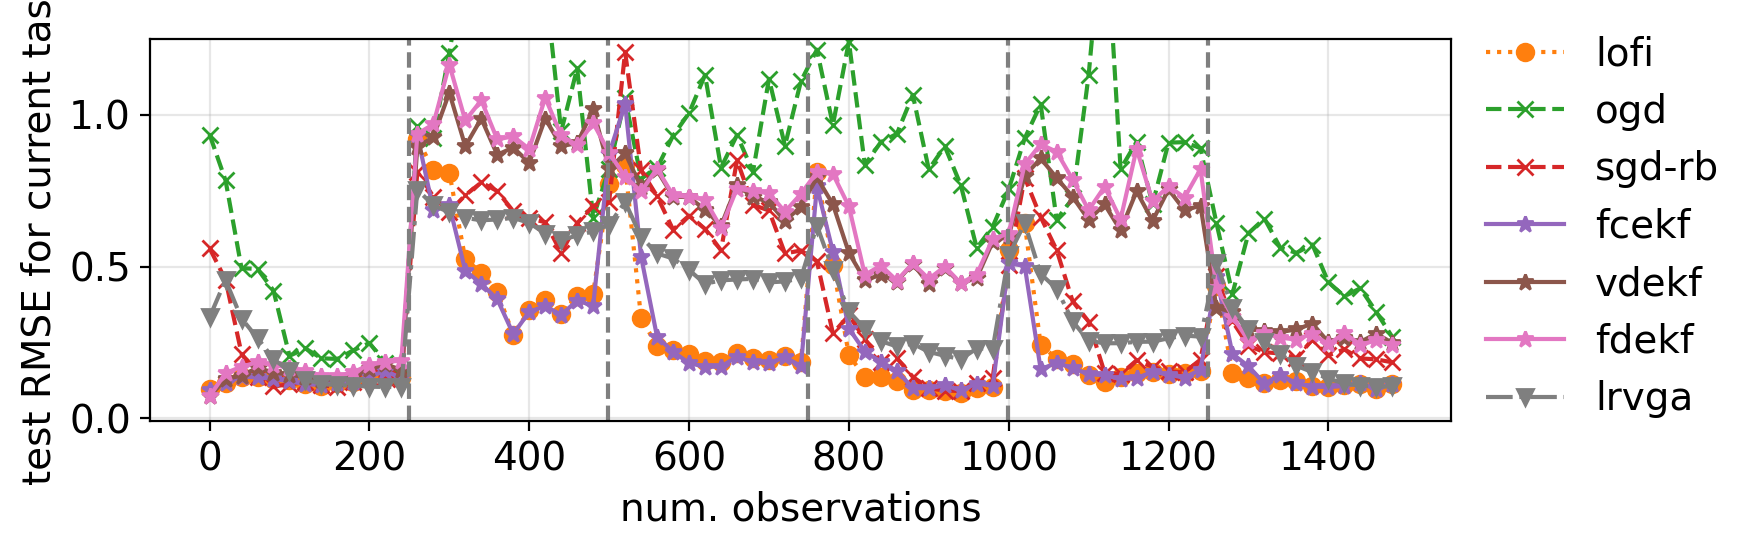

In [87]:
ntasks, ntrain_per_task, _ = X_train_tasks.shape
changepoints = np.arange(ntrain_per_task, (ntasks)*ntrain_per_task, step=ntrain_per_task)-1
color_dict, style_dict, marker_dict = make_plot_dict(method_list)

plt.figure(figsize=(9, 3))
for i, method in enumerate(method_list):
    ttl = '{:s}, elapsed={:0.2f}'.format(method, elapsed_list[i])
    kernel_size = 20
    
    if "sgd" in method:
        if "B 1 " in method:
            raw_method = "ogd"
        else:
            raw_method = "sgd-rb"
    else:
        raw_method = method.split(" ")[0]
    kernel = jnp.ones(kernel_size) / kernel_size
    rmse_trace = output_list[i]['rmse_test_current_task']
    rmse_smoothed = jnp.convolve(rmse_trace, kernel, mode='same')
    #rmse_smoothed = rmse_trace
    ndata = len(rmse_smoothed)
    ndx = np.arange(0, ndata, step=20) # thin the data so we can see the markers
    plt.plot(ndx, rmse_smoothed[ndx], label=raw_method, color=color_dict[method], linestyle=style_dict[method], marker=marker_dict[method])
    #plt.plot(ndx, rmse_smoothed[ndx], label=ttl, color=color_list[i], linestyle=style_list[i], marker=marker_list[i])
#plt.ylim([0, 1.5])

for c in changepoints:
    plt.axvline(x=c, color="tab:gray", linestyle="--")
# plt.legend(bbox_to_anchor=(0.7, -0.2), frameon=False)
plt.legend(bbox_to_anchor=(1, 1.1), frameon=False)
plt.ylabel('test RMSE for current task')
plt.xlabel('num. observations')
plt.grid(alpha=0.3)
plt.ylim(-0.01, 1.25)
plt.tight_layout()

plt.savefig(figdir + '/regression_plot_1d_lofi.pdf')
plt.savefig(figdir + '/regression_plot_1d_lofi.png')

In [88]:
output_total = {
    method: {
        "seconds": seconds,
        "output": output
    }
    for method, seconds, output in zip(method_list, elapsed_list, output_list)
}

In [89]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ttl, ax=None):
    if ax is None:
        fig, ax = plt.subplot()
    
    ixs_tr = np.argsort(Xtr, 0).ravel()
    ixs_te = np.argsort(Xte, 0).ravel()
    
    ax.plot(Xtr[ixs_tr], ytr[ixs_tr], color="black", label='train')
    ax.scatter(Xte[ixs_te], yte[ixs_te], color="tab:red", label='test', alpha=0.8)
    ax.scatter(Xte[ixs_te], yhat[ixs_te], color="tab:blue", label='pred', alpha=0.8)
    ax.set_xticklabels([])
    # ax.legend()

In [103]:
def plot_pred_task(task, outputs, ax, name='', offset=0):
    times = jnp.where(train_id_seq == task)
    last_time = times[0][-1]
    yhat = outputs['pred_test_current_task'][last_time,:]
    rmse = outputs['rmse_test_current_task'][last_time]
    mae = outputs['mae_test_current_task'][last_time]
    ttl = '{:s}, mae={:0.3f}'.format(name,  mae)
    plot_pred(X_train_tasks[task], Y_train_tasks[task], X_test_tasks[task], Y_test_tasks[task], yhat, ttl, ax)

CPU times: user 8.19 s, sys: 1.61 s, total: 9.8 s
Wall time: 6.13 s


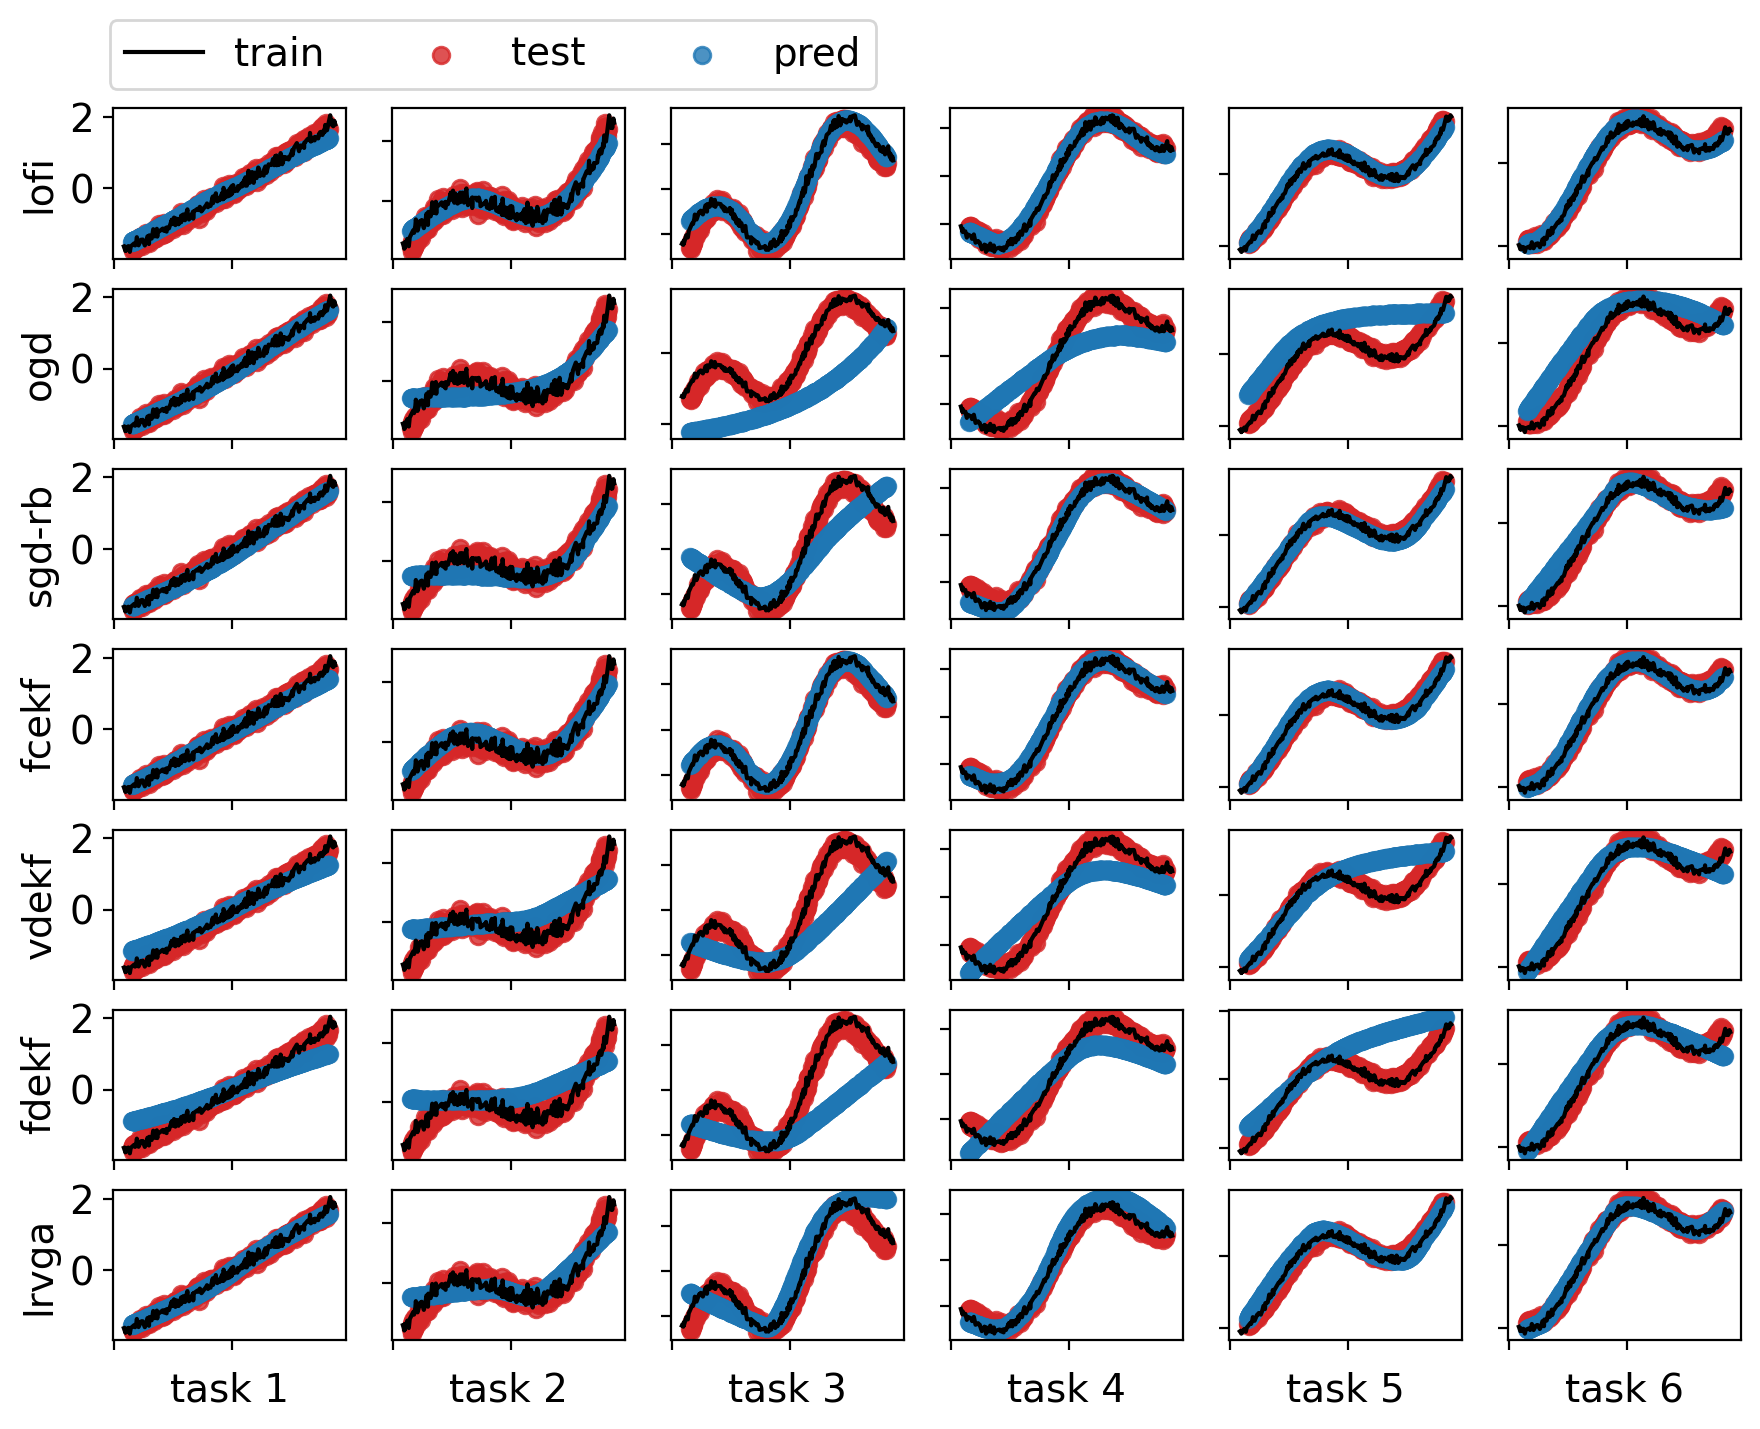

In [104]:
%%time
fig, axs_grid = plt.subplots(7, 6, figsize=(10.5,  8))

for axs, method in zip(axs_grid, method_list):
    outputs = output_total[method]["output"]
    if "B" in method:
        agent_name = "sgd-rb" if "B 10" in method else "ogd"
    else:
        agent_name = method.split(" ")[0].rstrip(",")
        
    for task, ax in enumerate(axs):
        plot_pred_task(task, outputs, ax, method)
        if task == 0:
            ax.set_ylabel(agent_name)
        else:
            ax.set_yticklabels([])

for t, ax in enumerate(axs):
    ax.set_xlabel(f"task {t+1}")
axs_grid[0, 0].legend(ncol=3, bbox_to_anchor=(-0.1, 1.0), loc="lower left")
# plt.tight_layout()
plt.savefig(figdir + '/regression_plot_1d_pred.png', dpi=200)

In [62]:
method_list

['lofi mem 10, q 0.01, alpha 0.01',
 'sgd lr 0.100 B 1 E 1',
 'sgd lr 0.100 B 10 E 1',
 'fcekf',
 'vdekf',
 'fdekf',
 'lrvga mem 10, alpha 0.995']

<timed exec>:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


CPU times: user 2.52 s, sys: 963 ms, total: 3.48 s
Wall time: 1.69 s


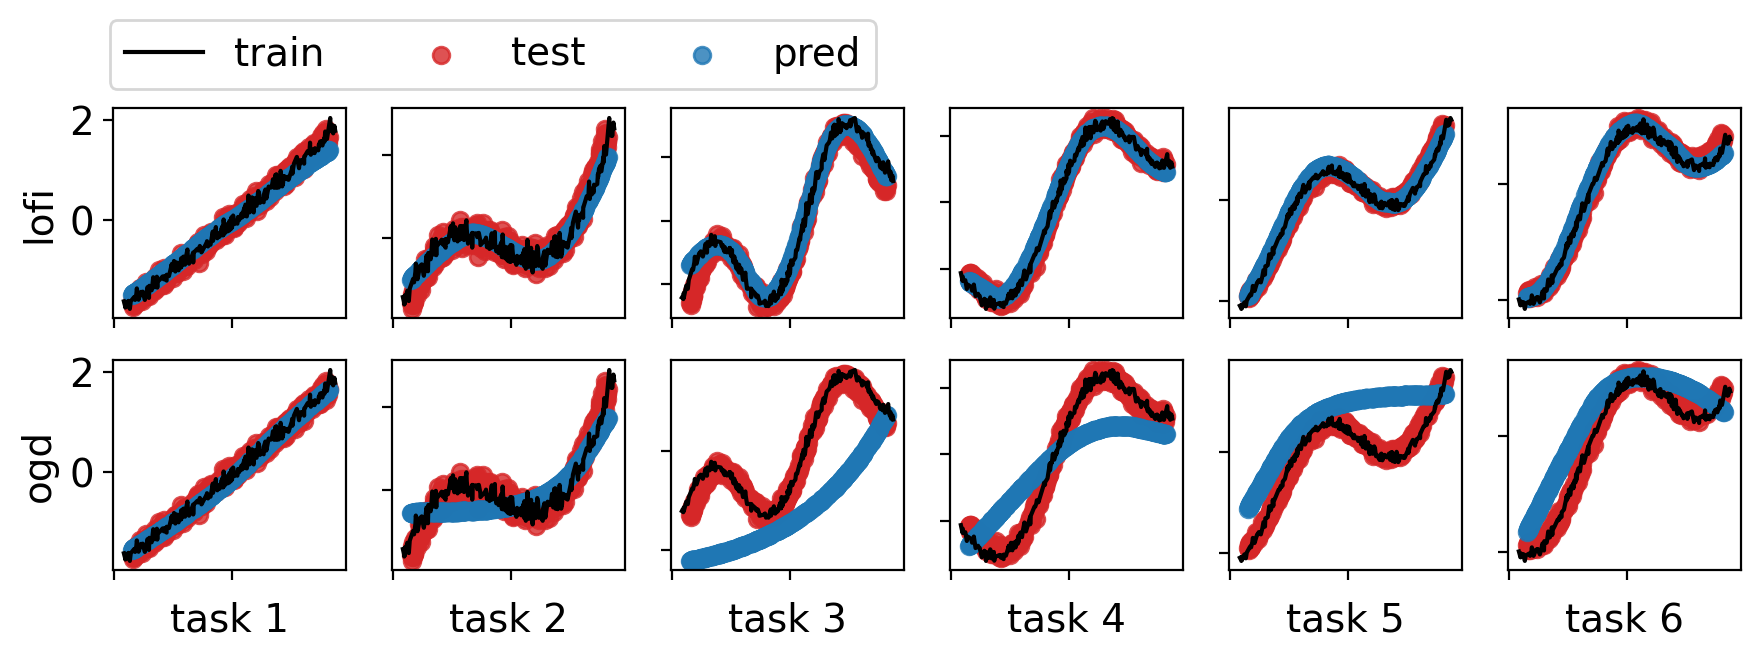

In [107]:
%%time
fig, axs_grid = plt.subplots(2, 6, figsize=(10.5,  3))

target_methods = [
    "lofi mem 10, q 0.01, alpha 0.01",
    "sgd lr 0.100 B 1 E 1"
]

for axs, method in zip(axs_grid, target_methods):
    
    outputs = output_total[method]["output"]
    if "B" in method:
        agent_name = "sgd-rb" if "B 10" in method else "ogd"
    else:
        agent_name = method.split(" ")[0].rstrip(",")
        
    for task, ax in enumerate(axs):
        plot_pred_task(task, outputs, ax, method)
        if task == 0:
            ax.set_ylabel(agent_name)
        else:
            ax.set_yticklabels([])

for t, ax in enumerate(axs):
    ax.set_xlabel(f"task {t+1}")
axs_grid[0, 0].legend(ncol=3, bbox_to_anchor=(-0.1, 1.0), loc="lower left")
plt.tight_layout()
plt.savefig(figdir + '/regression_plot_1d_pred_part.png', dpi=200)